# Package

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import time 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as sw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import re
import requests
import zipfile
import io
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import timeit
from sklearn.svm import SVC
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
!pip install plotly

In [4]:
#load data 
df = pd.read_csv("training.300000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")

In [5]:
df['sentiment'].value_counts()

4    150515
0    149485
Name: sentiment, dtype: int64

Number of entries with positive vs negative sentiment is roughly equal, don't need to worry about imbalanced data.

In [6]:
df['sentiment'] = df['sentiment'].replace(4, 1)

# Data Processing 

In [7]:
#delete punctuation, @names, and clean twitter text

import re
def clean_text(x):
    # Define a regular expression to match username tag,
    # alphanumeric characters and underscores
    user_tag_regex = r'@[A-Za-z0-9_]+'
    # Define a regular expression to match URLs
    url_regex = r'https?://\S+|www\.\S+'
    # Define a regular expression to match hashtags
    hashtag_regex = r'#\w+'

    # Remove email addresses
    x = re.sub(user_tag_regex, '', x)
    # Remove URLs
    x = re.sub(url_regex, '', x)
    # Remove hashtags
    x = re.sub(hashtag_regex, '', x)
    # remove punctuation and special characters
    x = re.sub(r'[^\w\s]','',x)
    # remove digits/numbers
    x = re.sub('[0-9]+','', x)
    # remove 3+ repeated characters in a row, substitute with 2
    pattern = r'(\w)(\1{2,})'
    substitution = r'\1\1'
    x = re.sub(pattern, substitution, x)
    # substitute words containing 'haha' into 'haha'
    pattern = re.compile(r'\b\w*haha\w*\b')
    x = pattern.sub('haha', x)
    # substitute words containing 'xox' into 'xo'
    pattern = re.compile(r'\b\w*xox\w*\b')
    x = pattern.sub('xo', x)
    # remove words with non-ASCII characters
    pattern = re.compile(r'[^\x00-\x7F]+')
    x = pattern.sub('', x)

    return x

df['text'] = [clean_text(text) for text in df['text']] 

### Data set split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size = 0.25, random_state = 0)

### Tokenisation

In [9]:
X_train = [word_tokenize(s) for s in X_train]
X_test = [word_tokenize(s) for s in X_test]

### Remove Stopwords

In [10]:
stop_words = sw.words()

X_train = [[w for w in tokens if not w in stop_words] for tokens in X_train]
X_test = [[w for w in tokens if not w in stop_words] for tokens in X_test]

### Lemmatisation

In [11]:
lemmatizer = WordNetLemmatizer()

X_train = [[lemmatizer.lemmatize(w) for w in tokens] for tokens in X_train]
X_test = [[lemmatizer.lemmatize(w) for w in tokens] for tokens in X_test]

### Vertorizer

In [54]:
vectorizer = TfidfVectorizer(analyzer = 'word', tokenizer = lambda x: x, 
                             preprocessor = lambda x: x, token_pattern = None,
                            norm = 'l2')
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

### Subseting for hyperparameter tunning

In [55]:
#susbet of training data for hyperparameter selection
X_train_hyper, _, y_train_hyper, _ = train_test_split(X_train, y_train, 
                                                     train_size = 0.01,
                                                     stratify = y_train,
                                                     random_state = 0)
print(X_train_hyper.shape)
print(X_train.shape)

(2250, 125502)
(225000, 125502)


# SVM + logistic regression

### Result plotting

Citation for the result plotting for grid search

“python - How to graph grid scores from GridSearchCV?” Stack Overflow, https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv. Accessed 16 May 2023.

In [56]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']
    mean_fit_time = results['mean_fit_time']
    mean_score_time = results['mean_score_time']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

### Grid search for Logistic regression

Grid search with solver:  liblinear
Fitting 5 folds for each of 10 candidates, totalling 50 fits


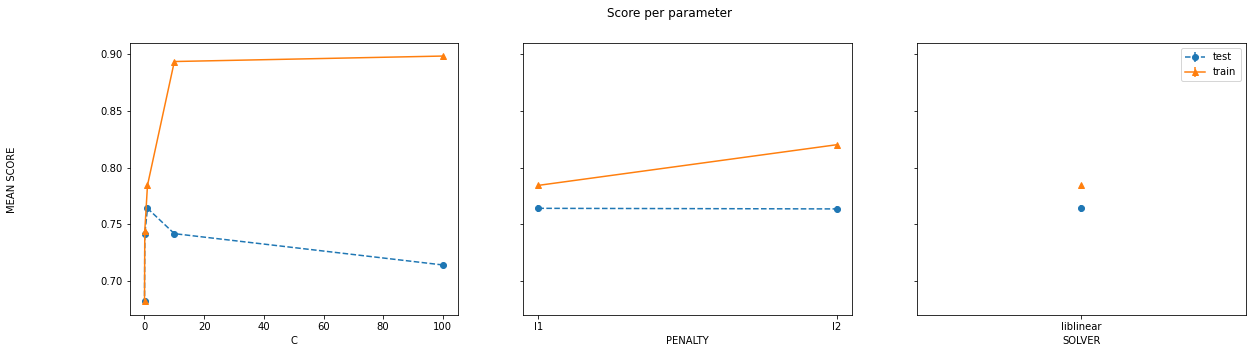

Grid search with solver:  sag
Fitting 5 folds for each of 5 candidates, totalling 25 fits


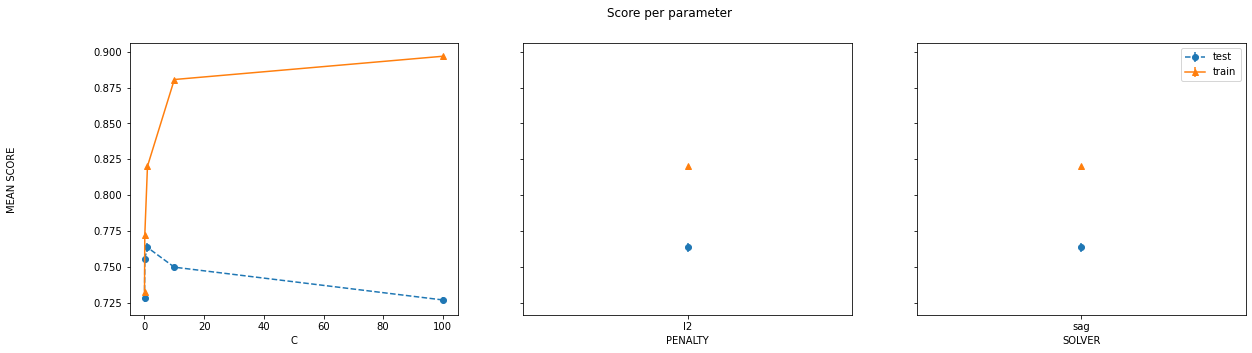

Best: 0.764041 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


In [57]:
solvers = ['liblinear', 'sag']
penalties_sag = ['l2']
penalties = ['l1', 'l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

model  = LogisticRegression(max_iter = 10000)
best_score = 0
best_solver = ''
best_params = {}

for solver in solvers:
    # penalties for liblinear are different than for the other solvers
    if solver == 'sag':
        penalty = penalties_sag
    else:
        penalty = penalties
        
    
    print('Grid search with solver: ', solver)
    param_grid = dict(solver = [solver], penalty = penalty, C = c_values)
    # cv with default n_splits = 5, n_repeats = 10
    #cv = RepeatedStratifiedKFold(random_state = 0)
    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                           n_jobs=-1, scoring='f1', verbose = 3,
                          return_train_score = True)
    grid_result = grid_search.fit(X_train, y_train)
    plot_search_results(grid_result)
    
    score = grid_result.best_score_
    params = grid_result.best_params_
    
    if score > best_score:
        best_score = score
        best_solver = solver
        best_params = params
        

print("Best: %f using %s" % (best_score, best_params))

### Logistic run time and confusion Matrix

Running time:  0.5534477233886719 s
Logistic regresson mean accuracy:  0.75292
Logistic regresson f1 score:  0.7626330553740922
              precision    recall  f1-score   support

           0       0.77      0.71      0.74     37371
           1       0.74      0.79      0.76     37629

    accuracy                           0.75     75000
   macro avg       0.75      0.75      0.75     75000
weighted avg       0.75      0.75      0.75     75000



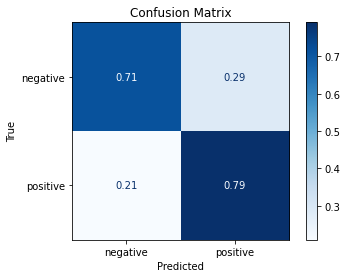

In [16]:
start_time = time.time()
lr = LogisticRegression(random_state = 0, max_iter = 10000, solver = 'liblinear', penalty = 'l1', C = 1.0)
lr.fit(X_train, y_train)
finish_time = time.time()

y_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_pred)
running_time = finish_time - start_time

print("Running time: ",running_time, 's')
print("Logistic regresson mean accuracy: ", lr.score(X_test, y_test))
print("Logistic regresson f1 score: ", f1)

print(classification_report(y_test, y_pred))

class_labels = ['negative', 'positive']

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels = class_labels,
                                       normalize = 'true',
                                       cmap = plt.cm.Blues)

# plot = plot_confusion_matrix(lr, X_test, y_test, 
#                              display_labels = None,
#                             cmap = plt.cm.Blues,
#                             normalize = 'true')
# Set plot labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

### Grid search for SVM

In [17]:
param_grid = {'C' : [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel' : ['rbf', 'poly', 'sigmoid', 'linear']}


grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, n_jobs=-1, return_train_score = True)
grid.fit(X_train_hyper, y_train_hyper)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best: 0.667556 using {'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}
[[21938 15433]
 [ 9701 27928]]
              precision    recall  f1-score   support

           0       0.69      0.59      0.64     37371
           1       0.64      0.74      0.69     37629

    accuracy                           0.66     75000
   macro avg       0.67      0.66      0.66     75000
weighted avg       0.67      0.66      0.66     75000



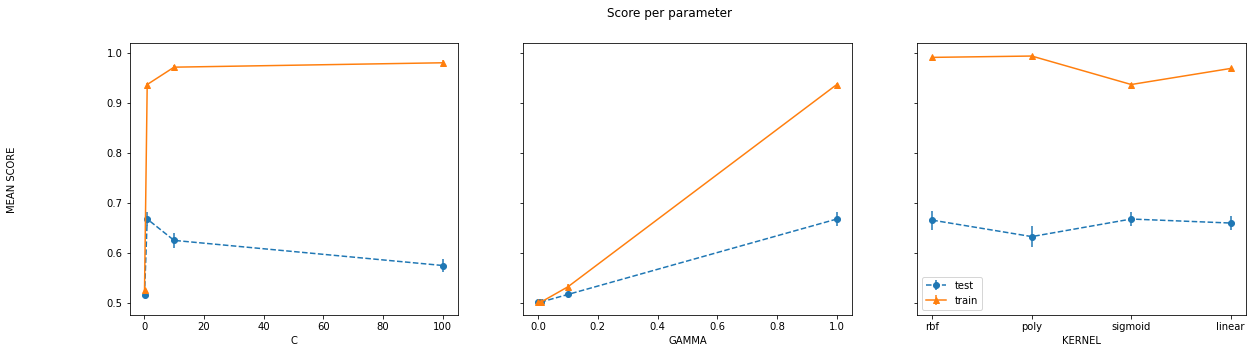

In [18]:
plot_search_results(grid)

### SVM Reuslt and Confusion Matrix

[LibSVM]Running time:  8935.210934638977 s
SVM mean accuracy:  0.7578266666666666
SVM f1 score:  0.765502549867665
[[27191 10180]
 [ 7983 29646]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     37371
           1       0.74      0.79      0.77     37629

    accuracy                           0.76     75000
   macro avg       0.76      0.76      0.76     75000
weighted avg       0.76      0.76      0.76     75000



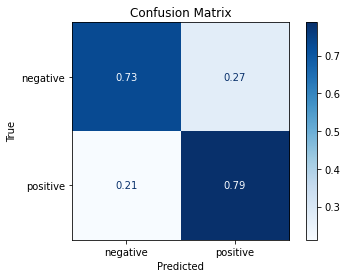

In [19]:
start = time.time()
svc = SVC(C = 1, gamma = 1, kernel = 'rbf', verbose = True, random_state = 0)
svc.fit(X_train, y_train)
finish = time.time()

running_time = finish - start

y_pred = svc.predict(X_test)
f1 = f1_score(y_test, y_pred)

print("Running time: ",running_time, 's')
print("SVM mean accuracy: ", svc.score(X_test, y_test))
print("SVM f1 score: ", f1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

class_labels = ['negative', 'positive']

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels = class_labels,
                                       normalize = 'true',
                                       cmap = plt.cm.Blues)
# Set plot labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# LSTM

### Pre processing

Citation: 
Dr. Jonathan Kay Kummerfeld, S1 2023, Lab 4: Word Classification and Machine Learning 2, Lab , COMP 4446 / 5046 Natural Language Processing, University of Sydney, delivered 8 March 2023.

In [12]:
raw_text = df["text"].tolist()
raw_label = df["sentiment"].tolist()

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(raw_text,raw_label,test_size=0.25,random_state=42)

In [13]:
X_train = [word_tokenize(s) for s in X_train]
X_test = [word_tokenize(s) for s in X_test]

In [14]:
stop_words = sw.words()

X_train = [[w for w in tokens if not w in stop_words] for tokens in X_train]
X_test = [[w for w in tokens if not w in stop_words] for tokens in X_test]

In [15]:
lemmatizer = WordNetLemmatizer()

X_train = [[lemmatizer.lemmatize(w) for w in tokens] for tokens in X_train]
X_test = [[lemmatizer.lemmatize(w) for w in tokens] for tokens in X_test]

### Padding

In [16]:
MAX_SEQUENCE_LENGTH = 30
tokenizer = Tokenizer()

# Train the tokenizer on the training data
tokenizer.fit_on_texts(X_train)

# Convert the training and testing data into padded sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

# Get the word-to-index mapping from the tokenizer
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Vocabulary Size : 100582
Training X Shape: (225000, 30)
Testing X Shape: (75000, 30)


### Label Encoding

In [17]:
#Get unique labels
unique_labels = np.unique(y_train)

# Create and fit the label encoder on the unique labels
lEnc = LabelEncoder()
lEnc.fit(unique_labels)
y_train = lEnc.transform(y_train)
y_test = lEnc.transform(y_test)

n_class = len(unique_labels)
print("y_train shape:", len(y_train))
print("y_test shape:", len(y_train))

y_train shape: 225000
y_test shape: 225000


### Embedding

Citation: JIGNESH PATEL, "NLP Beginner - Text Classification using LSTM", Kaggle, https://www.kaggle.com/code/jarvis11/nlp-beginner-text-classification-using-lstm#Model-Training---LSTM, accessed 14 May 2023

In [18]:
# Download the GloVe embeddings
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Extract the GloVe embeddings
zip_file.extractall()
zip_file.close()

In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
#Set the embedding dimention and number of epochs
EMBEDDING_DIM = 300
EPOCHS = 10

GLOVE_EMB = 'glove.6B.300d.txt'
embeddings_index = {}

#Get the words form the GloVe embedding file
f = open(GLOVE_EMB, 'r', encoding='utf-8')
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [21]:
#Create empty embedding matrix 
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

#Get the embedding vector from the GloVe matirx defined earlier
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

### Embedding layer

In [22]:
#Creating embedding layer 
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

### Model and hyperparameter tunning

Citation: JIGNESH PATEL, "NLP Beginner - Text Classification using LSTM", Kaggle, https://www.kaggle.com/code/jarvis11/nlp-beginner-text-classification-using-lstm#Model-Training---LSTM, accessed 14 May 2023

In [23]:
# Define the create_model function
def create_model(learning_rate, batch_size, dropout_rate):
    #set a timer for run time 
    start_time = timeit.default_timer()
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    #Apply spatial dropout to the embedded sequences
    x = SpatialDropout1D(dropout_rate)(embedding_sequences)
    #Apply a 1D convolutional layer with 64 filters and a filter size of 5
    x = Conv1D(64, 5, activation='relu')(x)
    #Apply a bidirectional LSTM layer with 64 units
    x = Bidirectional(LSTM(64, dropout=dropout_rate, recurrent_dropout=dropout_rate))(x)
    #Apply a dense layer with 512 units and ReLU activation function
    x = Dense(512, activation='relu')(x)
    #Apply dropout to the dense layer
    x = Dropout(dropout_rate)(x)
    # Apply a dense layer with 512 units and ReLU activation function
    x = Dense(512, activation='relu')(x)
    #Output layer with activation function sigmoid
    outputs = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(sequence_input, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model 
    
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=10,
                        validation_data=(x_test, y_test))
    #Stop timer for runtime 
    stop_time = timeit.default_timer()
    model_accuracy = history.history['val_accuracy'][-1]
    runing_time = stop_time - start_time
    return model, model_accuracy, runing_time


results = []

# Iterate over all combinations of hyperparameters
for learning_rate in [0.001, 0.01]:
    for batch_size in [512, 1024]:
        for dropout_rate in [0.2, 0.3]:
            # Create the model
            model, model_accuracy, running_time = create_model(learning_rate, batch_size, dropout_rate)
            # Store the results
            results.append({
            #'embedding_dim': embedding_dim,
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'dropout_rate': dropout_rate,
                'accuracy': model_accuracy,
                'running_time': running_time
            })

# Sort the results by accuracy in descending order
results = sorted(results, key=lambda x: x['accuracy'], reverse=True)

# Print the results
for result in results:
    print("Hyperparameters:", result)

Epoch 1/10
440/440 [==============================] - 126s 277ms/step - loss: 0.5703 - accuracy: 0.6997 - val_loss: 0.5307 - val_accuracy: 0.7321
Epoch 2/10
440/440 [==============================] - 123s 280ms/step - loss: 0.5314 - accuracy: 0.7308 - val_loss: 0.5268 - val_accuracy: 0.7391
Epoch 3/10
440/440 [==============================] - 123s 281ms/step - loss: 0.5147 - accuracy: 0.7429 - val_loss: 0.5131 - val_accuracy: 0.7457
Epoch 4/10
440/440 [==============================] - 122s 277ms/step - loss: 0.5023 - accuracy: 0.7512 - val_loss: 0.5147 - val_accuracy: 0.7480
Epoch 5/10
440/440 [==============================] - 120s 272ms/step - loss: 0.4930 - accuracy: 0.7589 - val_loss: 0.5158 - val_accuracy: 0.7461
Epoch 6/10
440/440 [==============================] - 118s 268ms/step - loss: 0.4847 - accuracy: 0.7639 - val_loss: 0.5116 - val_accuracy: 0.7483
Epoch 7/10
440/440 [==============================] - 119s 270ms/step - loss: 0.4770 - accuracy: 0.7684 - val_loss: 0.5165 -

### Plot

In [36]:
import plotly.express as px
# Extract the hyperparameters, accuracy, and running time into separate lists
hyperparameters = [f"lr={result['learning_rate']} bs={result['batch_size']} dr={result['dropout_rate']}" for result in results]
accuracy = [result['accuracy'] for result in results]
running_time = [result['running_time'] for result in results]

# Create the bar plot
fig = px.bar(x=hyperparameters, y=accuracy, color=running_time, text_auto ='.3f',
             labels={"x": "Hyperparameters", "y": "Accuracy", "color": "Run-time (Seconds)"},
             title="Accuracy of the LSTM model with different parameters",
             width=800, height=400)

# Update the appearance of the bars
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)

# Display the plot
fig.show()

### Model saving and prediction

In [37]:
# Extract the best hyperparameters and accuracy
best_hyperparameters = results[1]

# Save the model
model.save("best_model_lstm.h5")

In [38]:
best_hyperparameters

{'learning_rate': 0.001,
 'batch_size': 512,
 'dropout_rate': 0.3,
 'accuracy': 0.746999979019165,
 'running_time': 1058.91739}

In [39]:
import tensorflow as tf

# Load the saved model
saved_model_path = 'best_model_lstm.h5'
loaded_model = tf.keras.models.load_model(saved_model_path)

# Make predictions on the test set
predictions = loaded_model.predict(x_test)
# Apply the threshold and classify predictions as positive or negative
binary_predictions = np.where(predictions > 0.5, 'positive', 'negative')
print(binary_predictions)

2344/2344 [==============================] - 81s 35ms/step
[['negative']
 ['positive']
 ['negative']
 ...
 ['positive']
 ['negative']
 ['negative']]


### Confusion Matrix and classification report

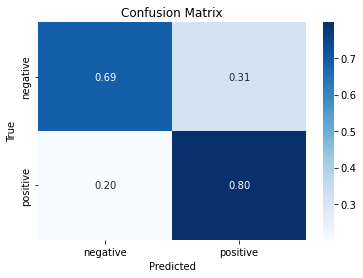

In [40]:
# Map string labels to numeric labels
label_mapping = {"negative": 0, "positive": 1}

# Convert binary_predictions to numeric labels
binary_predictions_numeric = np.zeros_like(binary_predictions)
for i in range(len(binary_predictions)):
    binary_predictions_numeric[i] = label_mapping[binary_predictions[i][0]]

binary_predictions_numeric = binary_predictions_numeric.astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, binary_predictions_numeric)

# Calculate probabilities from the confusion matrix
cm_probabilities = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_labels = ["negative", "positive"]

# Plot confusion matrix
sns.heatmap(cm_probabilities, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [41]:
# Generate classification report
report = classification_report(y_test, binary_predictions_numeric, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    negative       0.77      0.69      0.73     37248
    positive       0.72      0.80      0.76     37752

    accuracy                           0.74     75000
   macro avg       0.75      0.74      0.74     75000
weighted avg       0.75      0.74      0.74     75000

